In [1]:
DEBUG = False

In [2]:
import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
import os
import librosa
from torch.utils.data import Dataset, DataLoader

import timm

import random

import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import ModelCheckpoint#, StochasticWeightAveraging
# from pl_bolts.optimizers.lr_scheduler import LinearWarmupCosineAnnealingLR
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau
from warmup_scheduler import GradualWarmupScheduler
from typing import Optional

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, StratifiedKFold

from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor
import concurrent.futures
import time
import seaborn as sns

In [3]:
# from torchvision import transforms

In [4]:
# def mono_to_color(X: np.ndarray, mean=0.5, std=0.5, eps=1e-6):
#     trans = transforms.Compose([transforms.ToPILImage(),
#                                         transforms.Resize([224, 448]), transforms.ToTensor(),
#                                         transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])
#     X = np.stack([X, X, X], axis=-1)
#     V = (255 * X).astype(np.uint8)
#     V = (trans(V)+1)/2
#     return V

In [5]:
import albumentations as A
from albumentations.augmentations.crops.transforms import RandomCrop
from albumentations.pytorch import ToTensorV2


def get_transforms(*, data):
    
    if data == 'train':
        return A.Compose([
            A.Resize(224, 448),
            ToTensorV2(),
        ])

    elif data == 'valid':
        return A.Compose([
            A.Resize(224, 448),
            ToTensorV2(),
        ])

    elif data == 'None':
        return A.Compose([
            A.Resize(224, 448),
            ToTensorV2(),
        ])

    elif data == 'test':
        return A.Compose([
            A.Resize(224, 448),
            ToTensorV2(),
        ])

In [7]:
BASE_DIR = '../data/'
TRAIN_PATH = os.path.join(BASE_DIR, 'w2n_train')
TEST_PATH = os.path.join(BASE_DIR, 'w2n_test')
def read_wav2mel(path):
        # y, sr = librosa.load(path) # y: audio signal, sr = sampling rate
        y = np.load(path)

        n_fft = 892
        win_length = 892
        hop_length = 245
        n_mels = 224
        sr = 22050

        D = np.abs(librosa.stft(y, n_fft=n_fft, win_length = win_length, hop_length=hop_length))
        mel_spec = librosa.feature.melspectrogram(S=D, sr=sr, n_mels=n_mels, hop_length=hop_length, win_length=win_length)

        return mel_spec

def mfcc_extract(path):
    try:
        # y, sr  = librosa.load(filename, sr = 44100)
        # path = os.path.join(TRAIN_PATH, filename) + '.npy'
        y = np.load(path)
        sr = 22050
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13, n_fft=892, hop_length=int(245))
        return mfcc
    except:
        return


def get_mfcc(data, trans=None, is_train=True):
    if is_train:
        path, label= data
        path = os.path.join(TRAIN_PATH, path) + '.npy'
        mfcc_feat = mfcc_extract(path)
        
        if not trans is None:
            data = trans(image=mfcc_feat)
            mfcc_feat = data['image']
        
        return mfcc_feat, label-1
    else:
        path= data
        path = os.path.join(TEST_PATH, path) + '.npy'
        mfcc_feat = mfcc_extract(path)
        
        if not trans is None:
            data = trans(image=mfcc_feat)
            mfcc_feat = data['image']
        
        return mfcc_feat


def get_mel(data, trans=None, is_train=True):
    if is_train:
        path, label= data
        path = os.path.join(TRAIN_PATH, path) + '.npy'
        mel = read_wav2mel(path)
        
        if not trans is None:
            data = trans(image=mel)
            mel = data['image']
        
        return mel, label-1
    else:
        path= data
        path = os.path.join(TEST_PATH, path) + '.npy'
        mel = read_wav2mel(path)
        
        if not trans is None:
            data = trans(image=mel)
            mel = data['image']
        
        return mel

class WavDatset(Dataset):

    def __init__(self, df, trans=None, is_train=True):
        super().__init__()

        self.df = df
        self.is_train = is_train
        self.trans = trans

        if self.is_train:
            self.data = []
            print("Load Train mode dataset ...")
            start = time.time()
            with ThreadPoolExecutor(max_workers=60) as executor:
                future_to_list = {executor.submit(get_mel, j, self.trans, self.is_train): j for j in self.df[['file_name', 'age_']].values}
                for future in concurrent.futures.as_completed(future_to_list):
                    j = future_to_list[future]
                    try:
                        self.data.append(future.result())
                        
                    except Exception as exc:
                        print('%r generated an exception: %s' % (j, exc))
            elapsed = time.time() - start
            print("ThreadPool Elapsed {}".format(elapsed))

        else:
            self.data = []
            print("Load Inference mode dataset ...")
            start = time.time()
            with ThreadPoolExecutor(max_workers=60) as executor:
                future_to_list = {executor.submit(get_mel, str(j), self.trans, self.is_train): j for j in self.df['file_name'].values}
                for future in concurrent.futures.as_completed(future_to_list):
                    j = future_to_list[future]
                    try:
                        self.data.append(future.result())
                        
                    except Exception as exc:
                        print('%r generated an exception: %s' % (j, exc))
            elapsed = time.time() - start
            print("ThreadPool Elapsed {}".format(elapsed))

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        
        if self.is_train:
            return self.data[index][0], self.data[index][1]
        else:
            return self.data[index]
    
print("Dataset Test as Train mode ...")
df = pd.read_csv('../data/train_label.csv')[:100]
trans = get_transforms(data='train')
dataset = WavDatset(df, trans=trans)
mel, label = dataset[1]
print(mel.shape)
print(label)

print("Dataset Test as Inference mode ...")
infer_df = pd.read_csv('../data/sample_submission.csv')[:100]
infer_trans = get_transforms(data='test')
infer_dataset = WavDatset(infer_df, trans=infer_trans, is_train=False)
infer_mel = infer_dataset[1]
print(infer_mel.shape)

Dataset Test as Train mode ...
Load Train mode dataset ...
ThreadPool Elapsed 2.02404522895813
torch.Size([1, 224, 448])
4
Dataset Test as Inference mode ...
Load Inference mode dataset ...
ThreadPool Elapsed 1.930243730545044
torch.Size([1, 224, 448])


In [ ]:
# model =  timm.create_model(model_name='mobilenetv3_large_100', pretrained=True, in_chans=1)
# model.classifier = nn.Linear(model.classifier.in_features, 7)
# sample = torch.rand(32, 1, 128, 128)
# out = model(sample)
# out.shape

In [ ]:
# class ImgModel(nn.Module):
#     def __init__(self, backbone='mobilenetv3_large_100'):
#         super(ImgModel, self).__init__()

#         self.backbone = timm.create_model(model_name=backbone, pretrained=True, in_chans=1)
#         # self.backbone.classifier = nn.Linear(self.backbone.classifier.in_features, 7)


#         self.pool = nn.AdaptiveMaxPool2d(1)

#         out_features = self.backbone.classifier.in_features
#         self.fc = nn.Linear(out_features, 7)

#     def forward(self, x):
#         out = self.backbone.forward_features(x)
#         out = self.pool(out)
#         out = self.fc(out[:,:,0,0])
#         return out

# # unit test
# print("Model Test ...")
# model = ImgModel()
# sample = torch.rand(32, 1, 128, 128)
# out = model(sample)
# print(out.shape)
# # print(model)

In [8]:
class ImgModel(nn.Module):
    def __init__(self, backbone='tf_efficientnet_b0_ns'):
        super(ImgModel, self).__init__()

        self.backbone = timm.create_model(model_name=backbone, pretrained=True, in_chans=1)
        self.pool = nn.AdaptiveMaxPool2d(1)

        out_features = self.backbone.classifier.in_features
        self.fc = nn.Linear(out_features, 7)

    def forward(self, x):
        out = self.backbone.forward_features(x)
        out = self.pool(out)
        out = self.fc(out[:,:,0,0])

        return out

# unit test
print("Model Test ...")
model = ImgModel()
sample = torch.rand(32, 1, 128, 128)
out = model(sample)
print(out.shape)

Model Test ...
torch.Size([32, 7])


In [9]:
class GradualWarmupSchedulerV2(GradualWarmupScheduler):
    def __init__(self, optimizer, multiplier, total_epoch, after_scheduler=None):
        super(GradualWarmupSchedulerV2, self).__init__(optimizer, multiplier, total_epoch, after_scheduler)
    def get_lr(self):
        if self.last_epoch > self.total_epoch:
            if self.after_scheduler:
                if not self.finished:
                    self.after_scheduler.base_lrs = [base_lr * self.multiplier for base_lr in self.base_lrs]
                    self.finished = True
                return self.after_scheduler.get_lr()
            return [base_lr * self.multiplier for base_lr in self.base_lrs]
        if self.multiplier == 1.0:
            return [base_lr * (float(self.last_epoch) / self.total_epoch) for base_lr in self.base_lrs]
        else:
            return [base_lr * ((self.multiplier - 1.) * self.last_epoch / self.total_epoch + 1.) for base_lr in self.base_lrs]

def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

class LitClassifier(pl.LightningModule):
    """
    >>> LitClassifier(Backbone())  # doctest: +ELLIPSIS +NORMALIZE_WHITESPACE
    LitClassifier(
      (backbone): ...
    )
    """

    def __init__(
        self,
        scale_list = [0.25, 0.5], # 0.125, 
        backbone: Optional[ImgModel] = None,
        learning_rate: float = 0.0001,
    ):
        super().__init__()
        self.save_hyperparameters(ignore=['backbone'])
        if backbone is None:
            backbone = ImgModel()
        self.backbone = backbone
        self.criterion = nn.CrossEntropyLoss()

    def forward(self, batch):
        out = self.backbone.forward_features(batch)
        out = self.pool(out)
        out = self.fc(out[:,:,0,0])
        return out

    def training_step(self, batch, batch_idx):
        
        x, y = batch
        labels = y.long()

        output = self.backbone(x)

        loss = self.criterion(output, labels)
        
        try:
            pred = output.detach().cpu()
            pred = torch.argmax(pred, dim=1)
            acc=accuracy_score(labels.detach().cpu(), pred) 

            self.log("acc", acc, on_step= True, prog_bar=True, logger=True)
            self.log("Train Loss", loss, on_step= True,prog_bar=True, logger=True)
        
        except:
            pass

        return {"loss": loss, "predictions": output.detach().cpu(), "labels": labels.detach().cpu()}

    def training_epoch_end(self, outputs):

        preds = []
        labels = []
        
        for output in outputs:
            
            preds += output['predictions']
            labels += output['labels']

        labels = torch.stack(labels)
        preds = torch.stack(preds)
        

    def validation_step(self, batch, batch_idx):
        x, y = batch
        output = self.backbone(x)
        labels = y.long()

        loss = self.criterion(output, labels)
        
        self.log('val_loss', loss, on_step= True, prog_bar=True, logger=True)
        return {"predictions": output, "labels": labels}

    def validation_epoch_end(self, outputs):

        preds = []
        labels = []
        for output in outputs:
            # preds.append(output['predictions'])
            # labels.append(output['labels'])
            preds += output['predictions']
            labels += output['labels']
        labels = torch.stack(labels)
        preds = torch.stack(preds)
        preds = preds.detach().cpu()
        preds = torch.argmax(preds, dim=1)
        val_acc=accuracy_score(labels.detach().cpu(), preds)
        self.log("val_acc", val_acc, prog_bar=True, logger=True)

    def test_step(self, batch, batch_idx):
        out = self.backbone(batch)
        return out

    def configure_optimizers(self):

        param_optimizer = list(self.backbone.named_parameters()) # self.model.named_parameters()
        no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
        optimizer_parameters = [
            {
                "params": [
                    p for n, p in param_optimizer if not any(nd in n for nd in no_decay)
                ],
                "weight_decay": 1e-6,
            },
            {
                "params": [
                    p for n, p in param_optimizer if any(nd in n for nd in no_decay)
                ],
                "weight_decay": 0.0,
            },
        ]

        optimizer = torch.optim.AdamW(optimizer_parameters, lr=self.hparams.learning_rate)
        scheduler_cosie = CosineAnnealingLR(optimizer, T_max= 10, eta_min=1e-6, last_epoch=-1)
        # scheduler_warmup = GradualWarmupSchedulerV2(optimizer, multiplier=1, total_epoch=5, after_scheduler=scheduler_cosie)
        return dict(optimizer=optimizer, lr_scheduler=scheduler_cosie) # , lr_scheduler=scheduler_warmup lr_scheduler=scheduler[optimizer], [scheduler]

class MyDataModule(pl.LightningDataModule):

    def __init__(
        self,
        TRAIN_DF,
        VALID_DF,
        batch_size: int = 32,
    ):
        super().__init__()
        
        trn_dataset = WavDatset(TRAIN_DF, trans=get_transforms(data='train')) 
        val_dataset = WavDatset(VALID_DF, trans=get_transforms(data='valid')) 
        
        self.train_dset = trn_dataset
        self.valid_dset = val_dataset
        self.batch_size = batch_size

    def train_dataloader(self):
        return DataLoader(self.train_dset, batch_size=self.batch_size, shuffle=True, num_workers=8)

    def val_dataloader(self):
        return DataLoader(self.valid_dset, batch_size=self.batch_size, shuffle=False, num_workers=8) 

def cli_main():
    logger = WandbLogger(name=f'CNN_mobilev3_224448_fold_{C_FOLD}', project='sp_recog')
    classifier =  LitClassifier()
    mc = ModelCheckpoint('model_mobilev3_224448', monitor='val_acc', mode='max', filename='{epoch}-{val_acc:.4f}_' + f'fold_{C_FOLD}')
    # swa = StochasticWeightAveraging(swa_epoch_start=2, annealing_epochs=2)
    trainer = pl.Trainer(
            gpus=1,
            max_epochs=100,
            # accelerator='ddp_spawn',
            # stochastic_weight_avg=True,
            callbacks=[mc],
            logger=logger
            )
    mydatamodule = MyDataModule(TRAIN_DF, VALID_DF)
    trainer.fit(classifier, datamodule=mydatamodule)

# Traninig

In [10]:
if DEBUG:
    print("======== DEBUG MODE =========")
    train_df = pd.read_csv('../data/train_label.csv')[:1000]
else:
    train_df = pd.read_csv('../data/train_label.csv')

# split fold
C_FOLD = 0
skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)

for i, (train_idx, valid_idx) in enumerate(skf.split(X=train_df, y=train_df['age_'])):

    if i == C_FOLD:
        TRAIN_DF = train_df.iloc[train_idx]

        VALID_DF = train_df.iloc[valid_idx]

seed_everything()
cli_main()


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


Load Train mode dataset ...
ThreadPool Elapsed 428.2954671382904
Load Train mode dataset ...


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


ThreadPool Elapsed 106.62432932853699


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: ygs (use `wandb login --relogin` to force relogin)



  | Name      | Type             | Params
-----------------------------------------------
0 | backbone  | ImgModel         | 5.3 M 
1 | criterion | CrossEntropyLoss | 0     
-----------------------------------------------
5.3 M     Trainable params
0         Non-trainable params
5.3 M     Total params
21.188    Total estimated model params size (MB)


Epoch 14:  76%|███████▌  | 602/791 [01:34<00:29,  6.37it/s, loss=0.0516, v_num=7w2k, acc=0.938, Train Loss=0.150, val_loss_step=0.109, val_loss_epoch=1.400, val_acc=0.584] 

/home/yilgukseo/anaconda3/envs/AI_hub_pre/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1046: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


Epoch 14:  76%|███████▌  | 602/791 [01:50<00:34,  5.45it/s, loss=0.0516, v_num=7w2k, acc=0.938, Train Loss=0.150, val_loss_step=0.109, val_loss_epoch=1.400, val_acc=0.584]

In [11]:
def make_test_dataloader():
    # Test Dataloader
    test_df = pd.read_csv('../data/sample_submission.csv')#[:100]
    test_dataset = WavDatset(test_df, trans=get_transforms(data='test'), is_train=False) #  images=test_images,
    test_dataloader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=10)
    return test_dataloader

In [12]:

class LitClassifier(pl.LightningModule):
    """
    >>> LitClassifier(Backbone())  # doctest: +ELLIPSIS +NORMALIZE_WHITESPACE
    LitClassifier(
      (backbone): ...
    )
    """

    def __init__(
        self,
        scale_list = [0.25, 0.5], # 0.125, 
        backbone: Optional[ImgModel] = None,
        learning_rate: float = 0.001,
    ):
        super().__init__()
        self.save_hyperparameters(ignore=['backbone'])
        if backbone is None:
            backbone = ImgModel()
        self.backbone = backbone

    def forward(self, batch):
        out = self.backbone.backbone.forward_features(batch)
        out = self.backbone.pool(out)
        out = self.backbone.fc(out[:,:,0,0])
        return out

In [13]:

weight_file = 'epoch=7-val_acc=0.5946_fold_0.ckpt' 
loade_model_path = f'../src/model_mobilev3_224448/{weight_file}'
model = LitClassifier()
model = model.load_from_checkpoint(loade_model_path).cuda().eval()

In [14]:
test_dataloader = make_test_dataloader()
pred_list = list()
with torch.no_grad():
    for i, x in enumerate(tqdm(test_dataloader)):
        pred = model(x.cuda())
        pred = pred.detach().cpu()#.sigmoid()
        pred = torch.argmax(pred, dim=1)
        pred_list.append(pred)

Load Inference mode dataset ...
Epoch 14:  76%|███████▌  | 602/791 [02:31<00:47,  3.97it/s, loss=0.0516, v_num=7w2k, acc=0.938, Train Loss=0.150, val_loss_step=0.109, val_loss_epoch=1.400, val_acc=0.584]
ThreadPool Elapsed 36.91880011558533


100%|██████████| 16/16 [00:03<00:00,  4.02it/s]


In [15]:
pred = torch.cat(pred_list)
len(pred)

1990

/home/yilgukseo/anaconda3/envs/AI_hub_pre/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


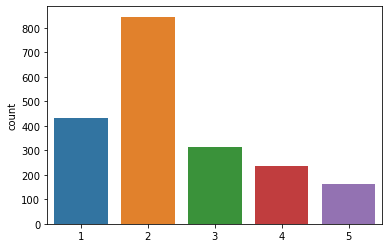

In [16]:
sns.countplot(pred.numpy());

In [17]:
sub = pd.read_csv('../data/sample_submission.csv')
sub['age_'] = pred.numpy() + 1
sub.to_csv('../sub/mel_b0_224_448size.csv', index=False)

In [18]:
sub['age_'].value_counts(normalize=True)

3    0.425126
2    0.216583
4    0.157286
5    0.118593
6    0.082412
Name: age_, dtype: float64